# Stages of Diabetic Retinopathy
## Общая структура работы и использованные материалы

### Вместе с ноутбуком в директории находятся следующие датасеты:
- Исходный, предоставленный для выполнения ДЗ, на 8000 изображений в папке `dataset/` (в нем находится папка `train/` с изображениями и `labels.csv`);
- Маленький датасет с [Kaggle](https://www.kaggle.com/datasets/mariaherrerot/idrid-dataset) в папке `kaggle_dataset/` (в нем находится `train/` c 455 изображениями и `idrid_labels.csv`)
- Большой датасет с [Kaggle](https://www.kaggle.com/c/diabetic-retinopathy-detection) в папке `gigaset/` (в нем находится `train/` c 35126 изображениями и `trainLabels.csv`).


### Ход работы:
1. Были изучены распределения изображений по классам для всех трех датасетов;
2. Были изучены размеры изображений предложенного датасета и получены минимальные ширина и высота;
3. Были сделаны попытки автоматически очистить исходный датасет от дефектных изображений. Было реализовано две идеи:
   - Эмпирический подбор значений средней интенсивности по каждому из каналов, выше и ниже которых изображение считалось дефектным;
   - Маленький датасет был проверен вручную и оказался "чистым". Он был взят за основу и было сделано предположение (которое позже было отвергнуто), что распределение средней интенсивности и ее дисперсии по каждому каналу подчиняется нормальному распределению. В связи с чем были получены доверительные интервалы на среднее значение и дисперсию интенсивности по каналам.
4. Был проведен анализ тестовой выборки для наибольшего датасета и выяснено, что там также присутствовали дефектные изображения, поэтому было принято решение не чистить обучающую выборку, так как и в тестирующей выборке ожидались дефектные изображения;
5. В файле `preproccess.py` была проведена предобработка всех используемых изображений (ее также придется сделать для Ваших изображений, чтобы модель работала корректно);
6. В `cnn.ipynb` была предложена и обучена модель сверточной нейронной сети, а также были проведены оценки основных метрик: accuracy, precision, recall, f1 score.
7. Тензоры с весами (state_dict-ы) обученных моделей лежат в папке `models/`:
   -  Две модели обученные на исходном датасете `8k_*.pth`;
   -  Одна модель обученная на большой датасете `35k_*.pth`.

## Exploratory data analysis
### Смотрим распределение изображений по классам
#### Исходный датасет

{0: 5912, 1: 530, 2: 1196, 3: 205, 4: 157}


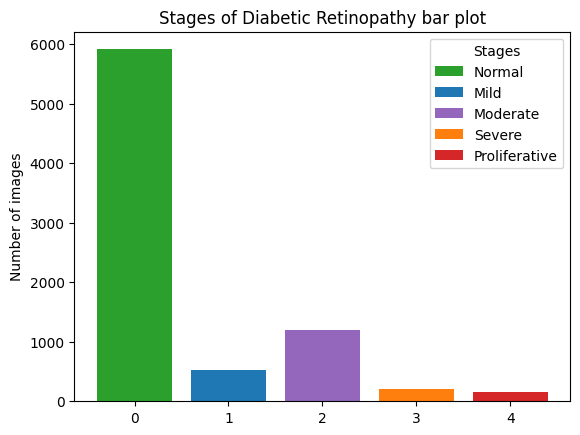

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('dataset/labels.csv')
levels = df.level.value_counts().to_dict()
levels = dict(sorted(levels.items(), key=lambda item: item[0]))
print(levels)

fig, ax = plt.subplots()
classes, counts = levels.keys(), levels.values()
bar_labels = ['Normal', 'Mild', 'Moderate', 'Severe', 'Proliferative']
bar_colors = ['tab:green', 'tab:blue', 'tab:purple', 'tab:orange', 'tab:red']
ax.bar(classes, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Number of images')
ax.set_title('Stages of Diabetic Retinopathy bar plot')
ax.legend(title='Stages')
plt.show()

#### Маленький датасет

{0: 129, 1: 22, 2: 156, 3: 84, 4: 64}


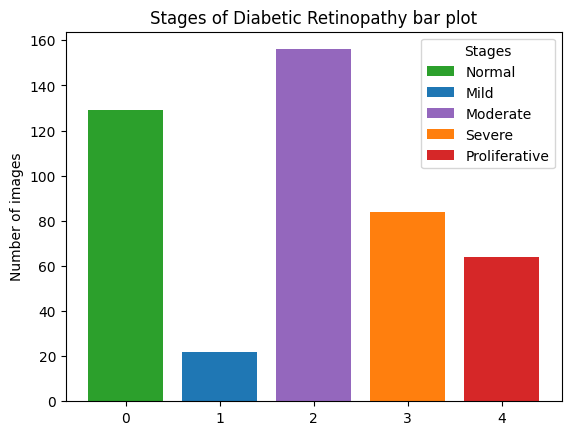

In [7]:
df = pd.read_csv('kaggle_dataset/idrid_labels.csv')
levels = df.diagnosis.value_counts().to_dict()
levels = dict(sorted(levels.items(), key=lambda item: item[0]))
print(levels)

fig, ax = plt.subplots()
classes, counts = levels.keys(), levels.values()
ax.bar(classes, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Number of images')
ax.set_title('Stages of Diabetic Retinopathy bar plot')
ax.legend(title='Stages')
plt.show()

#### Самый большой датасет

{0: 25810, 1: 2443, 2: 5292, 3: 873, 4: 708}


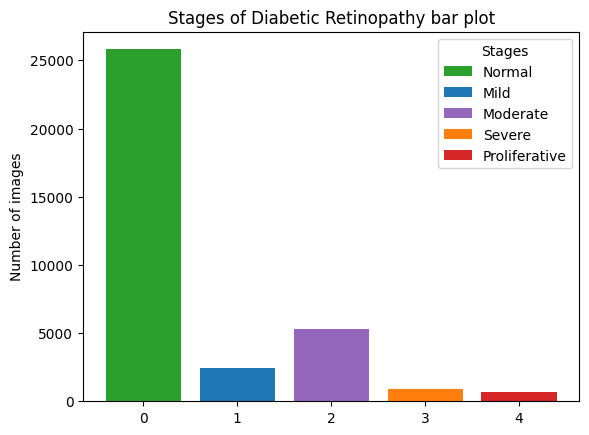

In [8]:
df = pd.read_csv('gigaset/trainLabels.csv')
levels = df.level.value_counts().to_dict()
levels = dict(sorted(levels.items(), key=lambda item: item[0]))
print(levels)

fig, ax = plt.subplots()
classes, counts = levels.keys(), levels.values()
ax.bar(classes, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Number of images')
ax.set_title('Stages of Diabetic Retinopathy bar plot')
ax.legend(title='Stages')
plt.show()

### Смотрим размеры изображений (размерность входных данных)

In [9]:
from PIL import Image
import os

path = 'dataset/train'
file_names = os.listdir(path)
widths, heights = [], []
for file in file_names:
    im = Image.open(f'{path}/{file}')
    width, height = im.size
    widths.append(width)
    heights.append(height)
width_min, height_min = min(widths), min(heights)
print(width_min, height_min)

400 289


### Работаем с маленьким датасетом с [Kaggle](https://www.kaggle.com/datasets/mariaherrerot/idrid-dataset)

In [10]:
kag_path = 'kaggle_dataset/train'
images = [file for file in os.listdir(kag_path) if file[-4:] == '.jpg']
kag = pd.DataFrame(columns=['file_name', 'red_mean', 'red_std', 'green_mean', 'green_std', 'blue_mean', 'blue_std'])

for index, image in enumerate(images):
    img = Image.open(f'{kag_path}/{image}')
    array = np.asarray(img)
    kag.loc[index] = [file[:-5], np.mean(array[:, :, 0]), np.std(array[:, :, 0]),
                     np.mean(array[:, :, 1]), np.std(array[:, :, 1]),
                     np.mean(array[:, :, 2]), np.std(array[:, :, 2])]

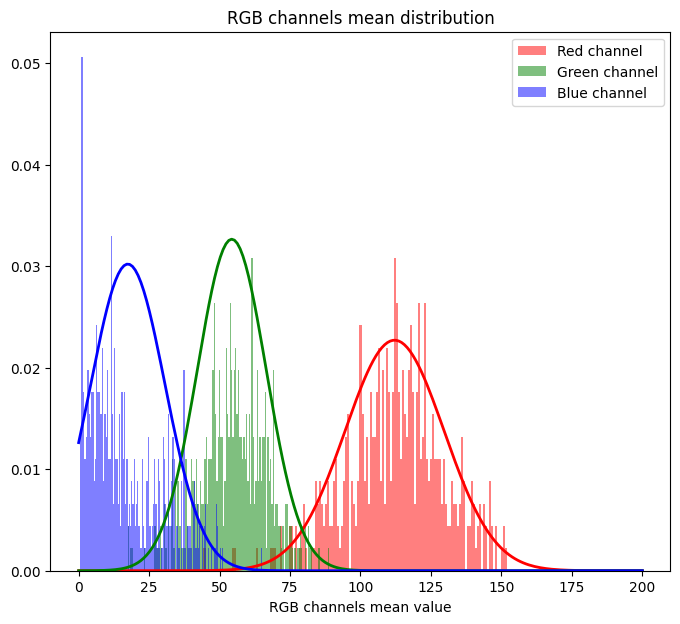

In [11]:
from scipy.stats import norm

intervals = {'red': {}, 'green':{}, 'blue': {}}

def hist_n_gauss(ax: plt.Axes, data: pd.Series, bins: int, color: str, label: str) -> tuple:
    x = np.linspace(0, 200, 200)
    k = 3
    hist, bin_edges = np.histogram(data, bins=bins)
    mu, std = norm.fit(data)
    hist = hist.astype(float)
    hist /= np.linalg.norm(hist, ord=1)
    ax.hist(bin_edges[:-1], bin_edges, weights=hist, alpha=0.5, color=color, label=label)
    ax.plot(x, norm.pdf(x, mu, std), color=color, linewidth=2)

    left = mu - k * std if mu - k * std >= 0 else 0
    right = mu + k * std if mu + k * std <= 255 else 255
    
    return (left, right)

bins = 150
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(1, 1, 1)
intervals['red']['mean'] = hist_n_gauss(ax, kag.red_mean, bins, 'red', 'Red channel')
intervals['green']['mean'] = hist_n_gauss(ax, kag.green_mean, bins, 'green', 'Green channel')
intervals['blue']['mean'] = hist_n_gauss(ax, kag.blue_mean, bins, 'blue', 'Blue channel')
ax.set_title('RGB channels mean distribution')
ax.set_xlabel('RGB channels mean value')
ax.legend()
plt.show()

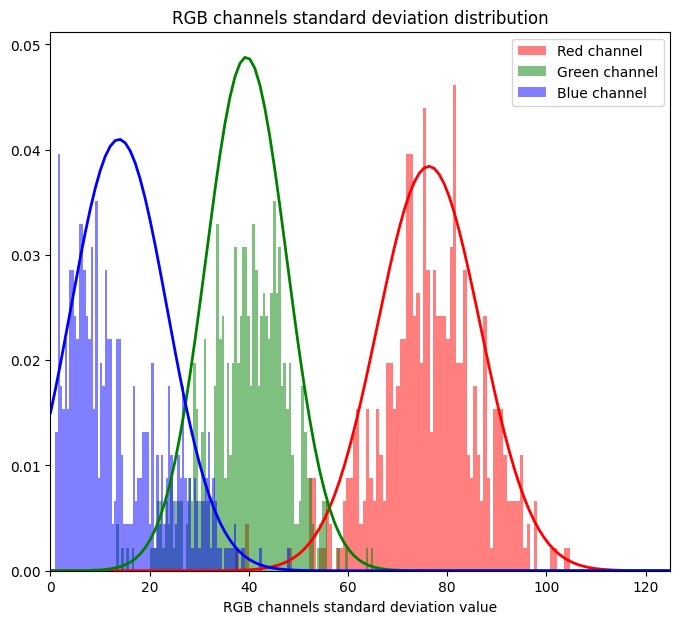

In [12]:
bins = 100
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(1, 1, 1)

intervals['red']['std'] = hist_n_gauss(ax, kag.red_std, bins, 'red', 'Red channel')
intervals['green']['std'] = hist_n_gauss(ax, kag.green_std, bins, 'green', 'Green channel')
intervals['blue']['std'] = hist_n_gauss(ax, kag.blue_std, bins, 'blue', 'Blue channel')
ax.set_title('RGB channels standard deviation distribution')
ax.set_xlabel('RGB channels standard deviation value')
ax.set_xlim(0, 125)
ax.legend()
plt.show()

In [13]:
intervals

{'red': {'mean': (59.379151941976, 164.81877539723737),
  'std': (45.14132476048064, 107.43514734035932)},
 'green': {'mean': (17.676757336908018, 90.99426539219712),
  'std': (14.955769759268883, 64.00854029651839)},
 'blue': {'mean': (0, 57.08503388502298), 'std': (0, 43.005229661709606)}}

### Смотрим на качество изображений исходного датасета

_Запуск следующей ячейки займет порядка **18 минут**, поэтому можете сходить прогуляться, отдохнуть, поразмышлять о смысле жизни..._

_Как у Вас дела? У меня все хорошо, диплом потихоньку пишется._

_Любите ли Вы творчество Булгакова? Я недавно решил перечитать Собачье сердце и Вам советую..._

In [14]:
df = pd.DataFrame(columns=['file_name', 'red_mean', 'red_std', 'green_mean', 'green_std', 'blue_mean', 'blue_std'])

for index, file in enumerate(file_names):
    img = Image.open(f'{path}/{file}')
    array = np.asarray(img)
    df.loc[index] = [file[:-5], np.mean(array[:, :, 0]), np.std(array[:, :, 0]),
                     np.mean(array[:, :, 1]), np.std(array[:, :, 1]),
                     np.mean(array[:, :, 2]), np.std(array[:, :, 2])]

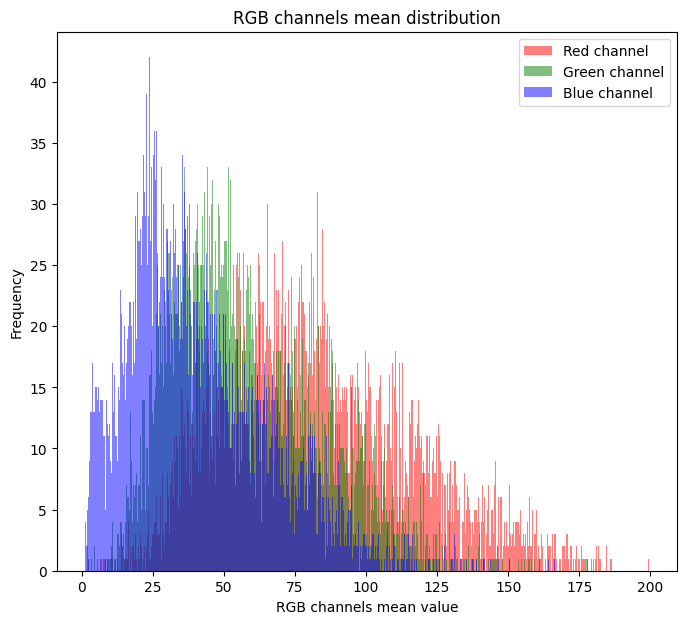

In [15]:
bins = 1000
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(1, 1, 1)
ax = df.red_mean.plot.hist(alpha=0.5, color='red', label='Red channel', bins=bins)
ax = df.green_mean.plot.hist(alpha=0.5, color='green', label='Green channel', bins=bins)
ax = df.blue_mean.plot.hist(alpha=0.5, color='blue', label='Blue channel', bins=bins)
ax.set_title('RGB channels mean distribution')
ax.set_xlabel('RGB channels mean value')
ax.legend()
plt.show()

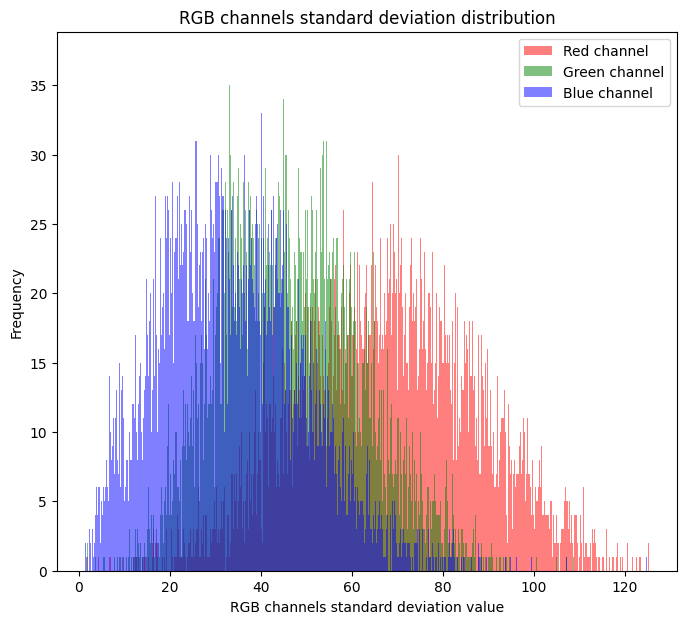

In [16]:
bins = 1000
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(1, 1, 1)
ax = df.red_std.plot.hist(alpha=0.5, color='red', label='Red channel', bins=bins)
ax = df.green_std.plot.hist(alpha=0.5, color='green', label='Green channel', bins=bins)
ax = df.blue_std.plot.hist(alpha=0.5, color='blue', label='Blue channel', bins=bins)
ax.set_title('RGB channels standard deviation distribution')
ax.set_xlabel('RGB channels standard deviation value')
ax.legend()
plt.show()

Попытки придумать эвристику для того, чтобы очистить датасет от слишком засветленных/затемненных изображений

In [17]:
max_mean = min(df.red_mean.max(), df.green_mean.max(), df.blue_mean.max())

def bad_images(mean: float, std: float) -> pd.DataFrame:
    return df[(df.red_mean <= mean) & (df.green_mean <= mean) & (df.blue_mean <= mean) | 
              (df.red_std <= std) & (df.green_std <= std) & (df.blue_std <= std) |
              (df.red_mean >= max_mean - mean) & (df.green_mean >= max_mean - mean) &
              (df.blue_mean >= max_mean - mean)]

def images_in_interval(df: pd.DataFrame, intervals: dict) -> pd.DataFrame:
    return df[((intervals['red']['mean'][0] <= df.red_mean) & (df.red_mean <= intervals['red']['mean'][1]) | 
              (intervals['green']['mean'][0] <= df.green_mean) & (df.green_mean <= intervals['green']['mean'][1]) | 
              (intervals['blue']['mean'][0] <= df.blue_mean) & (df.blue_mean <= intervals['blue']['mean'][1]))]

df1, df2 = bad_images(23, 23), bad_images(29, 29)
df3 = images_in_interval(df, intervals)

### Делаем копию исходного датасета, разбивая изображения по классам

In [18]:
# import shutil
# import pandas as pd
# import os

# df = pd.read_csv('dataset/labels.csv')
# data_dict = {image: level for image, level in zip(df.id_code.to_list(), df.diagnosis.to_list())}
# dirs = set(map(str, range(5)))

# path = 'preprocessed/test'
# for dir in dirs:
#     if dir not in os.listdir(path):
#         os.mkdir(f'{path}/{dir}')

# for file in os.listdir(path):
#     if file[-5:] == '.jpeg':
#         key = file[:-5]
#         shutil.move(f'{path}/{file}', f'{path}/{data_dict[key]}/{file}')